In [11]:
#libraries
import os
import random
import numpy as np
from PIL import Image,ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [12]:
train_dir = '/content/drive/MyDrive/Brain Tumor /Training'
test_dir = '/content/drive/MyDrive/Brain Tumor /Testing'

In [5]:
#load and shuffle the data

#training data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#testing data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

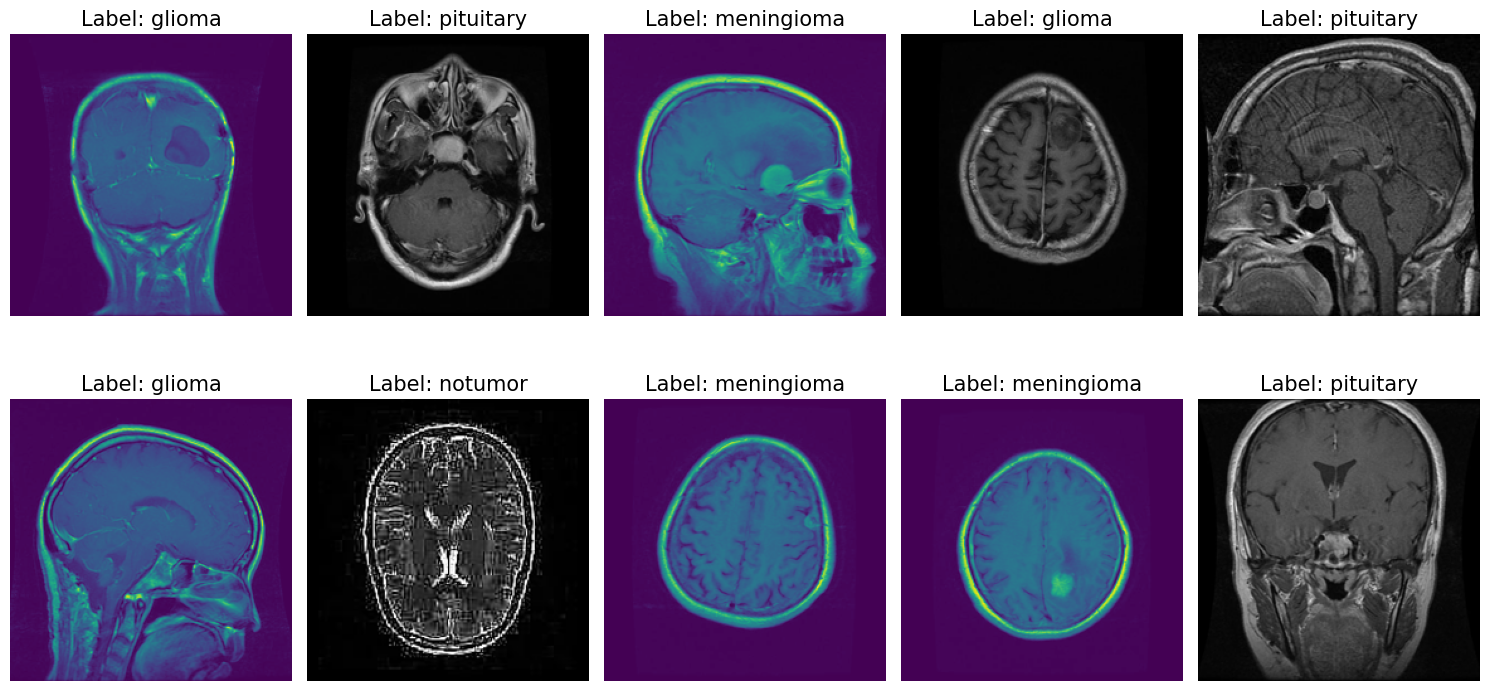

In [6]:
#data visualization
import matplotlib.pyplot as plt

#selected random 10 indexes
random_indices = random.sample(range(len(train_paths)),10)

fig, axes = plt.subplots(2,5,figsize = (15,8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  #load image
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((224,224))
  #display image
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label: {train_labels[idx]}", fontsize = 15)

plt.tight_layout()
plt.show()

In [7]:
#data preprocessing

# Image Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths, labels):
    images = []
    new_labels = []
    for path, label in zip(paths, labels):
        try:
            image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            image = augment_image(image)
            images.append(image)
            new_labels.append(label)
        except Exception as e:
            print(f"[Warning] Skipped file: {path} due to error: {e}")
    return np.array(images), new_labels

# Encoding labels
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images, valid_labels = open_images(batch_paths, batch_labels)
            valid_labels = encode_label(valid_labels)
            yield batch_images, valid_labels

In [8]:
#model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
#model building
model = Sequential()
model.add(Input(shape = (IMAGE_SIZE, IMAGE_SIZE , 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax'))

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
epochs = 5
batch_size = 20
steps = int(len(train_paths) / batch_size)

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps
)

Epoch 1/5
222/285 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.2783 - sparse_categorical_accuracy: 0.8997[Warning] Skipped file: /content/drive/MyDrive/Brain Tumor /Training/notumor/Tr-no_1573 (1).jpg due to error: cannot identify image file <_io.BytesIO object at 0x7d3c5a770400>
285/285 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - loss: 0.2701 - sparse_categorical_accuracy: 0.9020
Epoch 2/5
223/285 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9336[Warning] Skipped file: /content/drive/MyDrive/Brain Tumor /Training/notumor/Tr-no_1573 (1).jpg due to error: cannot identify image file <_io.BytesIO object at 0x7d3c5a789170>
285/285 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.9350
Epoch 3/5
224/285 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9534[Warning] Skipped file: /content/drive/MyDrive/Brain Tumor /Training/notumor/Tr-no_1573 (1).jpg due to error: cannot identify image file <_io

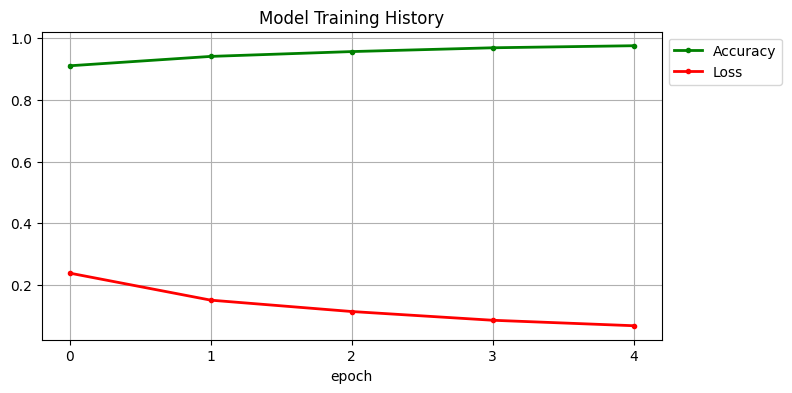

In [14]:
#plotting
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [16]:
#classification report

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

test_images, filtered_labels = open_images(test_paths, test_labels)
test_labels_encoded = encode_label(filtered_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       306
           1       0.94      0.95      0.95       300
           2       0.99      1.00      0.99       405
           3       0.89      0.99      0.94       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.94      1311



Confusion Matrix:
[[252  17   5  32]
 [  9 286   0   5]
 [  0   2 403   0]
 [  2   0   0 298]]


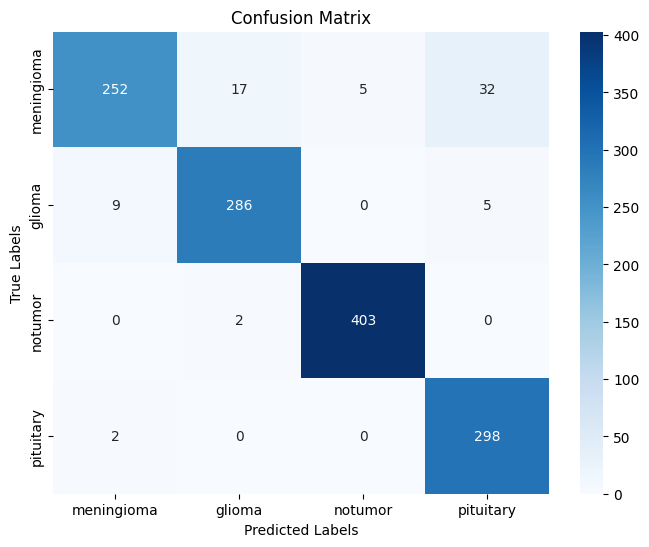

In [18]:
#confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

#plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

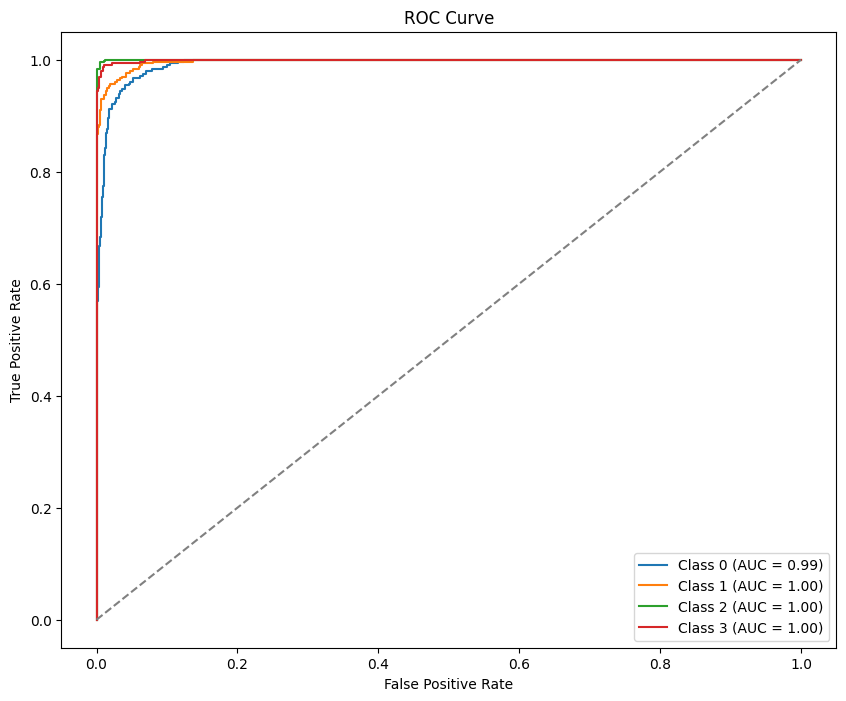

In [19]:
#ROC Curve and AUC

test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [23]:
#model save
model.save('brain_tumor_model.h5')